<a href="https://colab.research.google.com/github/mumerabbasi/NLP/blob/main/Multi_Class_Text_Classification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Importing from TF to build our classification model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, regularizers

#Installing and importing BERT Model and Tokenizer (to encode our Text)
!pip install modelzoo-client[transformers]
from transformers import BertTokenizer, TFBertModel

# To split Dataset
from sklearn.model_selection import train_test_split

In [5]:
# Initializing Google Colab's TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy() # to use CPU and single GPU

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.70.94.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.94.138:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [8]:
# Mounting Google Drive to access dataset file from your Drive
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/Datasets/YELP_Reviews_Data.csv'  # gdrive/My Drive/Folder Name/File Name.csv

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
# Setting different model parameters
num_class = 6
max_length = 512
test_df_size = 0.2
eval_df_size = 0.1
batch_size = 128
epochs = 5

In [10]:
# Reading data from file into a Pandas DataFrame
df =  pd.read_csv(path, sep='<')

# Dropping unecessary columns.
df = df[['text', 'stars']]

# Cleaning data
df.text = df['text'].astype(str)
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(subset=['stars'],inplace=True)

train_df, test_df = train_test_split(df, test_size = test_df_size, random_state = 42)
train_df, eval_df = train_test_split(train_df, test_size = eval_df_size, random_state = 42)

In [11]:
# Initializing BERT Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [12]:
# Function to encode whole dataset
# This function also pads or truncates each dataset observation (review) to make all observation have length equal to max_length
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding="max_length", truncation=True)
    return tf.constant(tokens["input_ids"])

# Encoding both the train and eval datasets
train_encoded = bert_encode(train_df.text)
eval_encoded = bert_encode(eval_df.text)

In [91]:
# One-Hot encoding the labels (stars)
train_labels = tf.keras.utils.to_categorical(train_df['stars'].values, num_classes=num_class)
eval_labels = tf.keras.utils.to_categorical(eval_df['stars'].values, num_classes=num_class)

# Building our final train and dev dataset with encoded text and encoded labels
train_dataset = (tf.data.Dataset.from_tensor_slices((train_encoded, train_labels)).shuffle(100).batch(batch_size))
eval_dataset = (tf.data.Dataset.from_tensor_slices((eval_encoded, eval_labels)).shuffle(100).batch(batch_size))

In [92]:
# Defining our BERT classification model
def bert_multi_class_classification_model():
    bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
    input_word_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    clf_output = Flatten()(last_hidden_states)
    net = Dense(512, activation="relu")(clf_output)
    net = Dropout(0.3)(net)
    net = Dense(440, activation="relu")(net)
    net = Dropout(0.1)(net)
    output = Dense(num_class, activation="softmax")(net)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [93]:
# Building our classification model on Colab's TPU
with tpu_strategy.scope():
    model = bert_multi_class_classification_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
    model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 512)]             0         
                                                                 
 tf_bert_model_5 (TFBertMode  TFBaseModelOutputWithPoo  108310272
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=((None, 12, None,             
                             512),                               
                              (None, 12, None, 512),       

In [94]:
# Training our BERT model
bert_model = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, validation_data=eval_dataset, verbose=1)

Epoch 1/5


1406/1406 [==============================] - 963s 618ms/step - loss: 0.9132 - accuracy: 0.6004 - val_loss: 0.7865 - val_accuracy: 0.6558
Epoch 2/5
1406/1406 [==============================] - 794s 564ms/step - loss: 0.7568 - accuracy: 0.6720 - val_loss: 0.7554 - val_accuracy: 0.6737
Epoch 3/5
1406/1406 [==============================] - 796s 566ms/step - loss: 0.6690 - accuracy: 0.7115 - val_loss: 0.7748 - val_accuracy: 0.6769
Epoch 4/5
1406/1406 [==============================] - 792s 564ms/step - loss: 0.5583 - accuracy: 0.7633 - val_loss: 0.8110 - val_accuracy: 0.6770
Epoch 5/5
1406/1406 [==============================] - 792s 563ms/step - loss: 0.4527 - accuracy: 0.8115 - val_loss: 0.8702 - val_accuracy: 0.6696


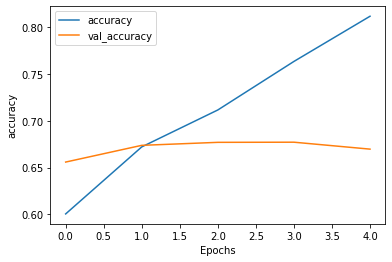

In [95]:
plt.plot(bert_model.history["accuracy"])
plt.plot(bert_model.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

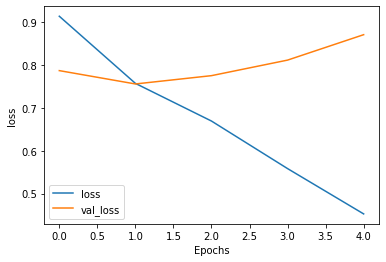

In [96]:
plt.plot(bert_model.history["loss"])
plt.plot(bert_model.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"])
plt.show()

In [13]:
# Let's run our model on our test data set

# Encoding test_df with bert encoder
test_df['text'] = test_df['text'].astype(str)
test_input_encoded = bert_encode(test_df['text'])

# One-Hot encoding the labels (stars)
test_labels = tf.keras.utils.to_categorical(test_df['stars'].values, num_classes=num_class)

In [109]:
# Evaluting model on test set
test_scores = model.evaluate(test_input_encoded, test_labels, verbose=1)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

1563/1563 [==============================] - 106s 66ms/step - loss: 0.8779 - accuracy: 0.6664
Test loss: 0.8778555393218994
Test accuracy: 0.6663732528686523


In [2]:
# Saving trained model in Google Drive
model_path = 'gdrive/My Drive/Colab Notebooks/NLP Trained Models/BERT_YELP_REVIEWS_EPOCH_5_1.h5'
model.save(model_path)

In [6]:
# Evaluting loaded model on test set
# This one runs faster but need more RAM
with tpu_strategy.scope():
  loaded_model = tf.keras.models.load_model(model_path, custom_objects={'TFBertModel':TFBertModel})
  

In [14]:
with tpu_strategy.scope():
  test_scores1 = loaded_model.evaluate(test_input_encoded, test_labels, verbose=1)
  print("Test loss:", test_scores1[0])
  print("Test accuracy:", test_scores1[1])

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


1563/1563 [==============================] - 124s 70ms/step - loss: 0.8779 - accuracy: 0.6664
Test loss: 0.8778555393218994
Test accuracy: 0.6663732528686523


Loaded Model Verified Successfully!